In [1]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model


from env_normalized import GridEnvironment
from DQL_agent import DQNAgent
from DQL_agent_noreplay import DQNAgent_nr

In [2]:
#NEW DATA TEST
caiso=pd.read_csv("CAISO_zone_1_.csv")

In [3]:
caiso.head

<bound method NDFrame.head of                         time  load_power  wind_power  solar_power  DHI  DNI  \
0        2018-01-01 00:00:00    0.785327    0.004276          0.0  0.0  0.0   
1        2018-01-01 00:01:00    0.784770    0.004346          0.0  0.0  0.0   
2        2018-01-01 00:02:00    0.784213    0.004416          0.0  0.0  0.0   
3        2018-01-01 00:03:00    0.783657    0.004486          0.0  0.0  0.0   
4        2018-01-01 00:04:00    0.783100    0.004556          0.0  0.0  0.0   
...                      ...         ...         ...          ...  ...  ...   
1573918  2020-12-30 23:56:00    0.847004    0.002288          0.0  0.0  0.0   
1573919  2020-12-30 23:57:00    0.846690    0.002437          0.0  0.0  0.0   
1573920  2020-12-30 23:58:00    0.846377    0.002587          0.0  0.0  0.0   
1573921  2020-12-30 23:59:00    0.846063    0.002736          0.0  0.0  0.0   
1573922  2020-12-31 00:00:00    0.845750    0.002885          0.0  0.0  0.0   

         GHI  Dew Poi

In [4]:
#Transform Data to our format
caiso['time'] = pd.to_datetime(caiso['time'])
caiso.set_index('time', inplace=True)

# Function to reshape the data
def reshape_data(df, column):
    # Resample data to daily frequency, and apply list to convert each day's data into a list
    daily_data = df[column].resample('D').apply(list)
    # Convert lists to a DataFrame, which inherently transposes the list to columns
    return pd.DataFrame(daily_data.tolist(), index=daily_data.index)

# Creating each DataFrame
demand_df = reshape_data(caiso, 'load_power')
solar_df = reshape_data(caiso, 'solar_power')
wind_df = reshape_data(caiso, 'wind_power')

def rename_columns(df):
    num_minutes = df.shape[1]
    time_labels = [str(pd.Timedelta(minutes=i)) for i in range(num_minutes)]
    df.columns = time_labels
    return df

demand_df = rename_columns(demand_df)
solar_df = rename_columns(solar_df)
wind_df = rename_columns(wind_df)

In [5]:
demand_caiso = np.array(demand_df)
solar_caiso = np.array(solar_df)*3
wind_caiso = np.array(wind_df)*4
net_caiso=demand_caiso-solar_caiso-wind_caiso

average_demand_per_minute = np.nanmean(demand_caiso, axis=0)
average_solar_per_minute = np.nanmean(solar_caiso, axis=0)
average_wind_per_minute = np.nanmean(wind_caiso, axis=0)

average_net_per_minute=average_demand_per_minute-average_solar_per_minute-average_wind_per_minute

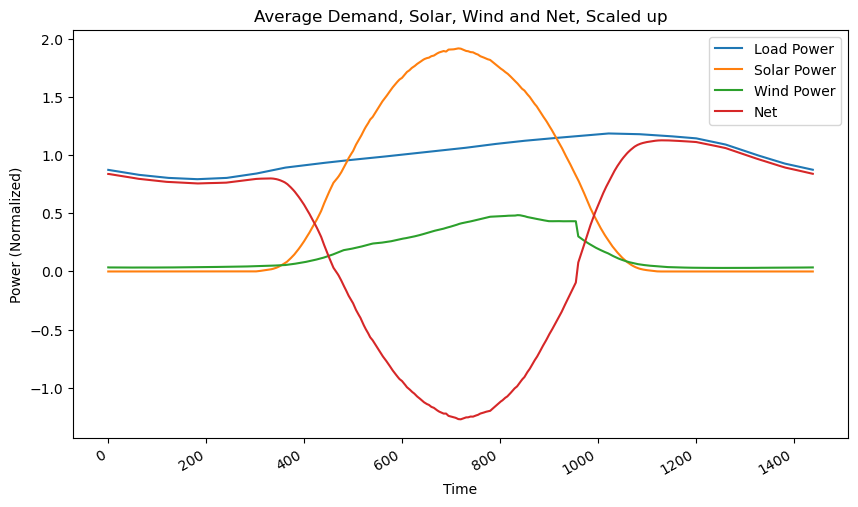

In [6]:
timestep_length=1 #in minutes
T=1440 # minutes in 24hrs

time_steps = np.arange(0, T * timestep_length, timestep_length)  # Generate a time axis\
plt.figure(figsize=(10, 6))
plt.plot(time_steps, average_demand_per_minute, label='Load Power')
plt.plot(time_steps, average_solar_per_minute, label='Solar Power')
plt.plot(time_steps, average_wind_per_minute, label='Wind Power')
plt.plot(time_steps, average_net_per_minute, label='Net')

# Adding titles and labels
plt.title('Average Demand, Solar, Wind and Net, Scaled up')
plt.xlabel('Time')
plt.ylabel('Power (Normalized)')
plt.legend()

# Rotating date labels for better visibility
plt.gcf().autofmt_xdate()

plt.show()

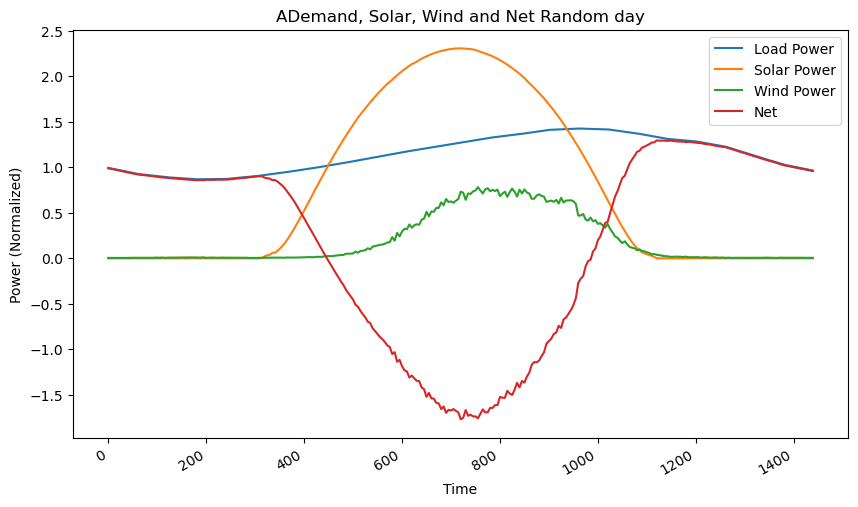

In [7]:
timestep_length=1 #in minutes
T=1440 # minutes in 24hrs
day_index=563 #random day

time_steps = np.arange(0, T * timestep_length, timestep_length)  
plt.figure(figsize=(10, 6))
plt.plot(time_steps, demand_caiso[day_index,:], label='Load Power')
plt.plot(time_steps, solar_caiso[day_index,:], label='Solar Power')
plt.plot(time_steps, wind_caiso[day_index,:], label='Wind Power')
plt.plot(time_steps, net_caiso[day_index,:], label='Net')

# Adding titles and labels
plt.title('ADemand, Solar, Wind and Net Random day')
plt.xlabel('Time')
plt.ylabel('Power (Normalized)')
plt.legend()

# Rotating date labels for better visibility
plt.gcf().autofmt_xdate()

plt.show()

In [8]:
#USING AGENT WITHOUT REPLAY ONE EPISODE
#Processing one episode without replay takes ~2minute
day_index=563 #random
timestep_length= (1/60) #in hours
batch_size = 10 #TWEAk
N=10
env = GridEnvironment(N, demand_caiso, solar_caiso, wind_caiso, day_index, timestep_length)
agent = DQNAgent_nr(state_size=env.state_size, action_size=env.action_size)


# Run for one episode (one day)
state = env.get_state()  # Reset environment to start state
total_reward = 0

T=1440 #(15 minute steps in 24 hrs)

demand_profile = np.zeros(T)
solar_profile = np.zeros(T)
wind_profile = np.zeros(T)
PEV_profile = np.zeros(T)

for timestep in range(1, T+1):  # Assume T timesteps in a day

    current_demand, current_solar, current_wind = env.get_state()
    current_P_EV=env.P_EV

    current_state=np.concatenate([np.array([current_demand, current_solar, current_wind]), np.array(current_P_EV)])
    action = agent.act(state)  # Decide action based on current state

    # Execute action in the environment and observe the next state, reward, and done flag
    reward, done, next_demand, next_solar, next_wind, next_P_EV = env.step(action)


    # Update profiles for plotting
    demand_profile[timestep - 1] = next_demand
    solar_profile[timestep - 1] = next_solar
    wind_profile[timestep - 1] = next_wind
    PEV_profile[timestep - 1] = np.sum(next_P_EV)
    

    # Construct the new state from the separated components
    next_state = np.concatenate([np.array([next_demand, next_solar, next_wind]), np.array(next_P_EV)])
    
    # Directly learn from this transition without using replay
    agent.learn(current_state, action, reward, next_state, done)

    # Update state and total_reward
    state = next_state
    total_reward += reward
    

    if done:
        # Handle episode completion, if applicable
        break

print("Total reward for the episode (day):", total_reward)




2024-04-12 21:25:17.121221: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Total reward for the episode (day): -1354.3304436053077


In [9]:
demand_profile.shape

(1440,)

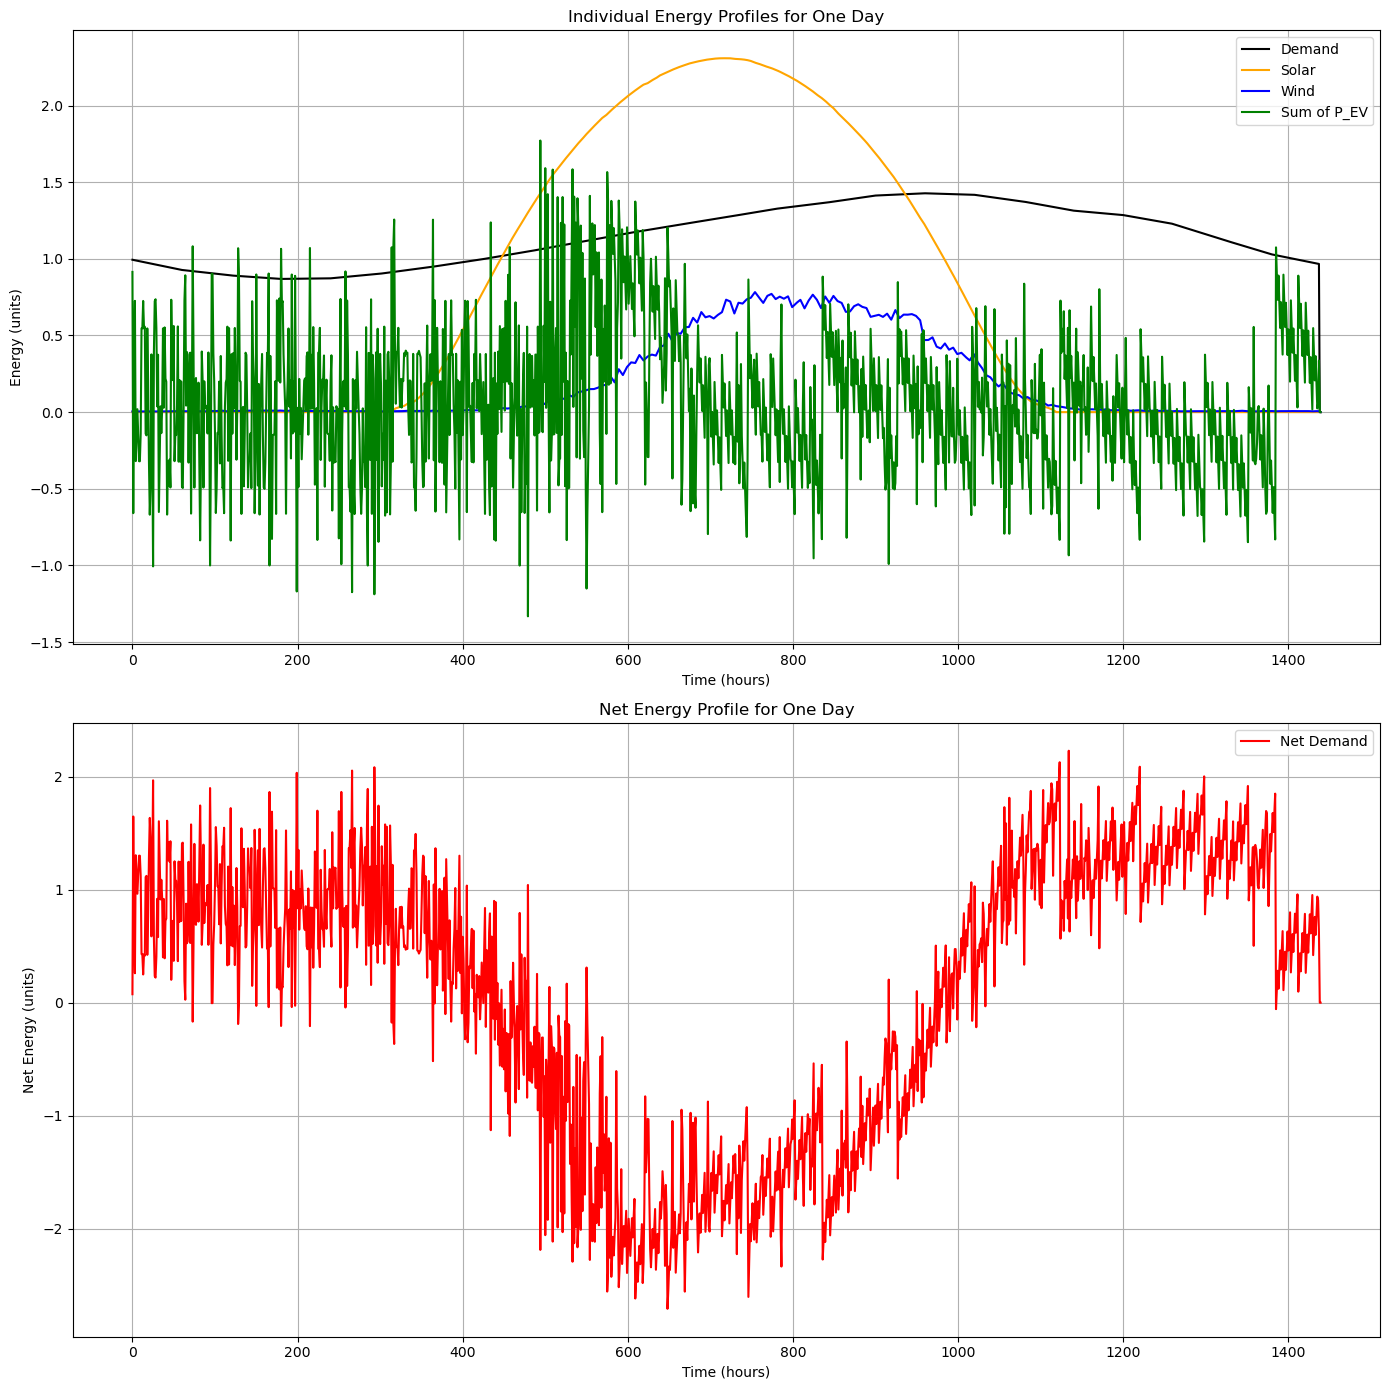

In [10]:

time_steps = np.arange(0, T, 1)  # Generate a time axis

plt.figure(figsize=(14, 14))  # Increase the figure size to accommodate two subplots

# First subplot for individual profiles
plt.subplot(2, 1, 1)  # (rows, columns, panel number)
plt.plot(time_steps, demand_profile, label='Demand', color='black')
plt.plot(time_steps, solar_profile, label='Solar', color='orange')
plt.plot(time_steps, wind_profile, label='Wind', color='blue')
plt.plot(time_steps, PEV_profile, label='Sum of P_EV', color='green')
plt.xlabel('Time (hours)')
plt.ylabel('Energy (units)')
plt.title('Individual Energy Profiles for One Day')
plt.legend()
plt.grid(True)

# Second subplot for net demand
plt.subplot(2, 1, 2)  # (rows, columns, panel number)
net_demand_profile = demand_profile - solar_profile - wind_profile-PEV_profile
plt.plot(time_steps, net_demand_profile, label='Net Demand', color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Net Energy (units)')
plt.title('Net Energy Profile for One Day')
plt.legend()
plt.grid(True)

# Show both plots
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure
plt.show()

In [11]:
#Attempt to loop through multiple episodes
#50 episodes=122 minutes
day_index=500 
timestep_length=(1/60) #in hours
batch_size = 32 #TWEAk
N=10
env = GridEnvironment(N, demand_caiso, solar_caiso, wind_caiso, day_index, timestep_length)

# Initialize DQN agent
agent = DQNAgent_nr(state_size=env.state_size, action_size=env.action_size)

## Initialize DQN agent
agent = DQNAgent_nr(state_size=env.state_size, action_size=env.action_size)

for day_index in range(50):  # Loop over 50 episodes
    # Initialize environment for the current day
    env = GridEnvironment(N, demand_caiso, solar_caiso, wind_caiso, day_index, timestep_length)
    
    # Reset environment to start state for the new episode
    state = env.reset(day_index)  # Assuming reset method is correctly set up to also return the initial state

    total_reward = 0
    T = 1440  # Assume T timesteps in a day

    demand_profile = np.zeros(T)
    solar_profile = np.zeros(T)
    wind_profile = np.zeros(T)
    PEV_profile = np.zeros(T)

    for timestep in range(1, T+1):  # Loop through each timestep in the day

        current_demand, current_solar, current_wind = env.get_state()
        current_P_EV = env.P_EV

        current_state = np.concatenate([np.array([current_demand, current_solar, current_wind]), np.array(current_P_EV)])
        action = agent.act(current_state)  # Ensure to pass the current state, not the initial state

        # Execute action in the environment and observe the next state, reward, and done flag
        reward, done, next_demand, next_solar, next_wind, next_P_EV = env.step(action)

        # Update profiles for plotting
        demand_profile[timestep - 1] = next_demand
        solar_profile[timestep - 1] = next_solar
        wind_profile[timestep - 1] = next_wind
        PEV_profile[timestep - 1] = np.sum(next_P_EV)

        # Construct the new state from the separated components
        next_state = np.concatenate([np.array([next_demand, next_solar, next_wind]), np.array(next_P_EV)])
        
        # Directly learn from this transition without using replay
        agent.learn(current_state, action, reward, next_state, done)

        # Update state and total_reward
        state = next_state
        total_reward += reward

        if done:
            break

    print(f"Total reward for day {day_index}: {total_reward}")



Total reward for day 0: -546.481334168394
Total reward for day 1: -360.23716534331345
Total reward for day 2: -428.0589030381983
Total reward for day 3: -313.17710899028424
Total reward for day 4: -338.82800434396563
Total reward for day 5: -250.03798506409169
Total reward for day 6: -421.2376565326597
Total reward for day 7: -385.1683021947116
Total reward for day 8: -302.9908400086308
Total reward for day 9: -241.23584945082965
Total reward for day 10: -330.13953561908306
Total reward for day 11: -363.3558542861545
Total reward for day 12: -415.8949235484361
Total reward for day 13: -376.84471928076516
Total reward for day 14: -337.8012694399273
Total reward for day 15: -370.6895457639064
Total reward for day 16: -350.359673764483
Total reward for day 17: -498.69952625596454
Total reward for day 18: -322.3434002546699
Total reward for day 19: -380.0728118398582
Total reward for day 20: -363.1428967895657
Total reward for day 21: -365.99318856689996
Total reward for day 22: -406.44493

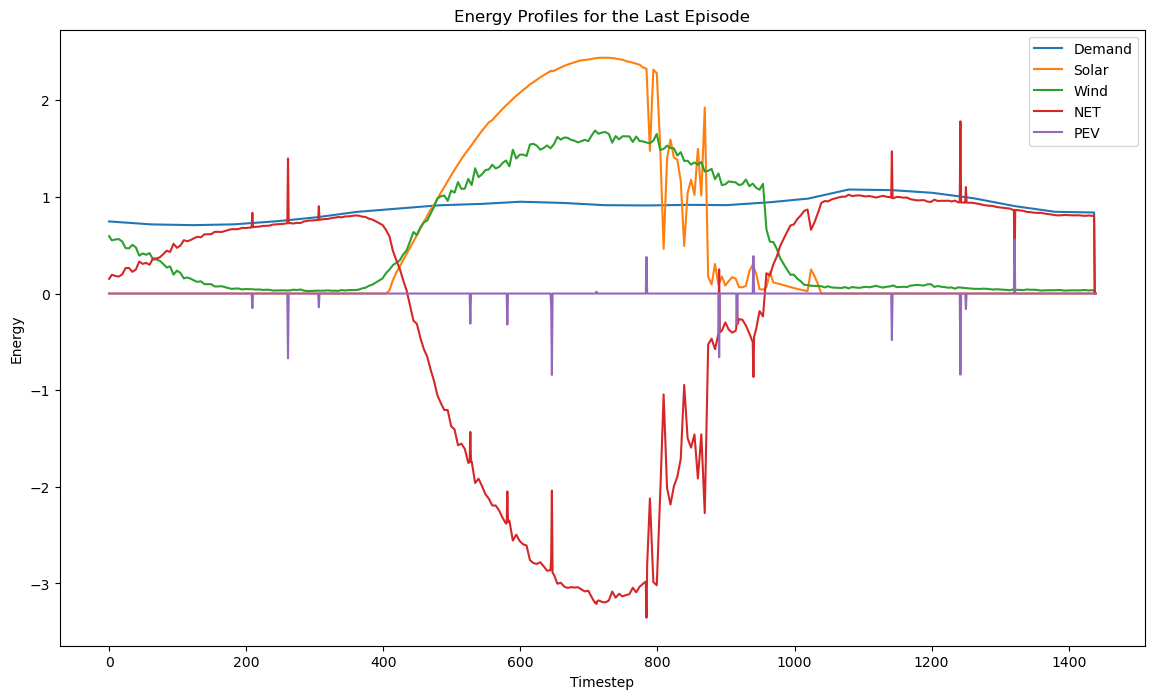

In [13]:
plt.figure(figsize=(14, 8))
plt.plot(demand_profile, label='Demand')
plt.plot(solar_profile, label='Solar')
plt.plot(wind_profile, label='Wind')
plt.plot(demand_profile-solar_profile- wind_profile-PEV_profile, label='NET')
plt.plot(PEV_profile, label='PEV')
plt.legend()
plt.title('Energy Profiles for the Last Episode')
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.show()